# Intersection over Union (IoU)

In the object detection problems, the goal is to accuractly predict the location of an object within an image with a bounding box that encompasses the boundaries of the object. The metric that is typically used to quanitfy this accuracy is called __Intersection over Union (IoU)__. In this notebook, we will demonstrate how to compute this metric.

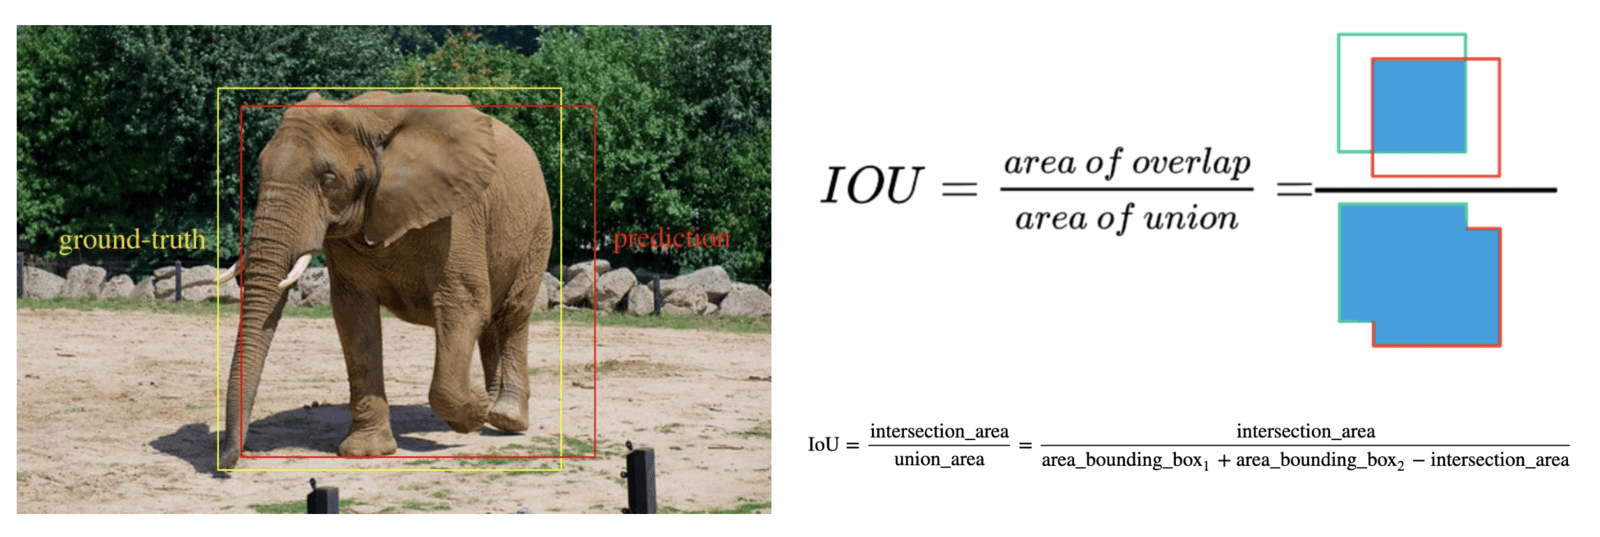

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 10)

## 1. Plotting Bounding Boxes

`pathces.rectangle` of `matplotlib` is used to a bounding box. it requires _x-min_, _y-min_, _width_ and _height_.

_width_ and _height_ can be calculated as follows:

_width = x-max - x-min + 1_

_height = y-max - y-min + 1_

__Why is it required to add a 1 after subtracting min from max?__

Since the width and height are represented in terms of pixels, they are not continuous but just discrete numbers.

The bounding box is represented in the form of _[x-min, y-min, x-max, y-max]_. Here, (_x-min_, _y-min_) and (_x-max_, _y-max_) both are part of the bounding box

In [3]:
def plot_bounding_box(dbox_data):
    """
    "Plot bounding boxes"
    
    dbox_data (tf.Variable): a tensor of bounding boxes. 
                             Format: [
                             [x_min, y_min, x_max, y_max, ...],
                             [x_min, y_min, x_max, y_max, ...],
                                         :
                                         :
                             [x_min, y_min, x_max, y_max, ...],
                             
                             ] 
    """
    
    # Calculate width and height for all boxes.
    # width = x_max - x_min + 1, x_max column index 2 and x_min column index is 0.
    # height = y_max - y_min + 1, y_max column index 3 and y_min column index is 1
    
    width = dbox_data[:, 2] - dbox_data[:, 0] + 1
    height = dbox_data[:, 3] - dbox_data[:, 1] + 1
    
    color = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
    fig = plt.figure(figsize=(15, 15))       
    
    ax = fig.add_subplot(111, aspect='equal')
    
    for i in range(tf.shape(dbox_data)[0]):
        ax.add_patch(
            patches.Rectangle(
                (dbox_data[i, 0], dbox_data[i, 1]),
                width[i],
                height[i],
                fill=False,      # remove background
                color=color[i%len(color)],
                linewidth = 3,
                label = '{}'.format(i)
            ) 
        )
        
    ax.legend()
    
    plt.xticks(range(0, 1050, 50))
    plt.yticks(range(0, 1050, 50))
        
    plt.show()
    
    return

In [4]:
# Bounding boxes / detections.
detections = tf.Variable([
    [100, 100, 500, 600],
    [150, 320, 570, 620],
    [50, 150, 450, 800],
    [550, 300, 900, 500]
],
    dtype=tf.float32
)

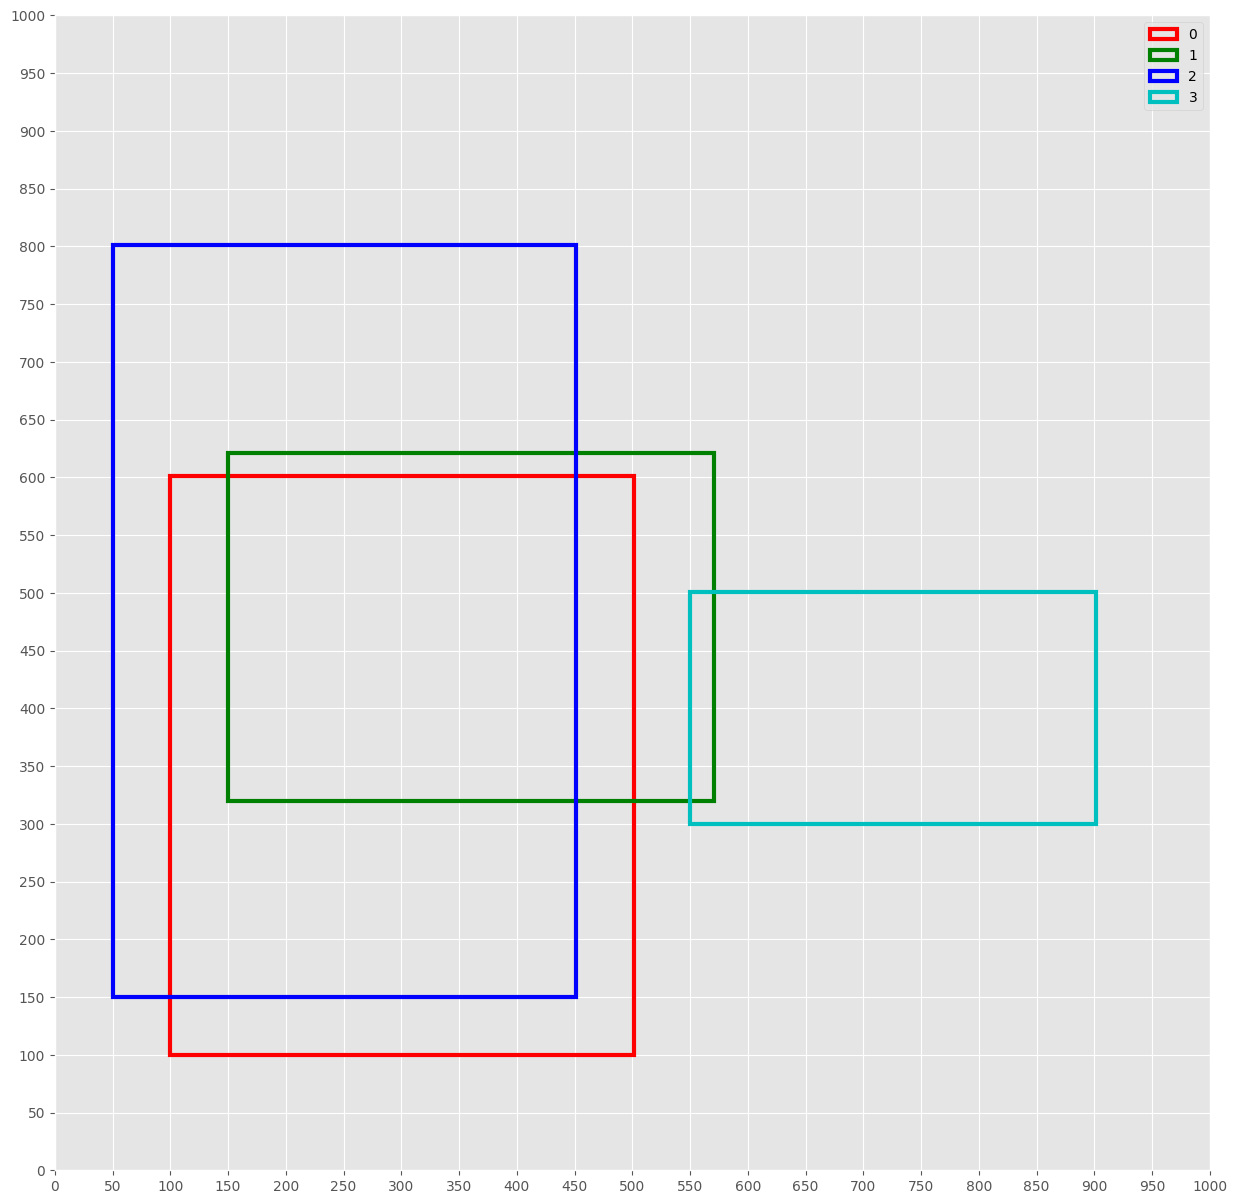

In [5]:
# Plot bounding boxes.
plot_bounding_box(detections)

## 2. Computing IoU

__Here is the algorithm that is implemented below to compute the IoU of two bounding boxes:__

+ Calculate the __width__ and __height__ of bounding boxes one and two.
+ Calculate __area_bounding_box_1__ and __area_bounding_box_2__ using the width and height for bounding boxes one and two, respectively.
+ Calculate coordinates of the overlapped rectangle of the two bounding boxes.
+ Calculate the width and height of the intersection (overlap) using its coordinates.
+ Change negative widths and heights to zero.
+ Calculate the area of the intersection, __intersection_area__ using intersection width and height.
+ Use the following formula to calculate IoU


$$
\text{IoU} = \frac{\text{intersection\_area}}{\text{area\_bounding\_box}_1 + \text{area\_bounding\_box}_2 - \text{intersection\_area}}
$$

In [6]:
def intersection_over_union(dbox_data, area=None):
    """
    "Calculates IoU of the 0th indexed bounding box with the rest of the boxes ([1:]). "
    
    dbox_data (tf.Variable): a tensor of bounding boxes. 
                             Format: [
                             [x_min, y_min, x_max, y_max, ...],
                             [x_min, y_min, x_max, y_max, ...],
                                         :
                                         :
                             [x_min, y_min, x_max, y_max, ...],
                             
                             ]
                             
    area (tf.Variable): area of the bounding boxes.
                        Foramt: [area_of_bounding_box_1, area_of_bounding_box_2, ....]
                        
                        default is None. If area is None, the function calculates the area and use it. 
                        
    return (tensor): IoU of the 0th indexed bounding box with the rest of the boxes. Lenght will be one less than 
                     the number of bounding box.
    """
    
    # Calculates area if it is None.
    if area is None:
        
        # Calculate width and height.
        width = dbox_data[:, 2] - dbox_data[:, 0] + 1
        height = dbox_data[:, 3] - dbox_data[:, 1] + 1
        
        area = tf.multiply(width, height)
        
    # Identify the overlap box coordinates.
    xx1 = tf.math.maximum(dbox_data[0, 0], dbox_data[1:, 0])
    yy1 = tf.math.maximum(dbox_data[0, 1], dbox_data[1:, 1])
    xx2 = tf.math.minimum(dbox_data[0, 2], dbox_data[1:, 2])
    yy2 = tf.math.minimum(dbox_data[0, 3], dbox_data[1:, 3])

    # Get size of the overlap sides and suppress negative values.
    intersection_width = tf.math.maximum((xx2 - xx1 + 1), tf.Variable(0.0, dtype=tf.float32))
    intersection_height = tf.math.maximum((yy2 - yy1 + 1), tf.Variable(0.0, dtype=tf.float32))

    # IoU calculation.
    intersection_area = intersection_width * intersection_height
    iou = intersection_area / (area[0] + area[1:] - intersection_area)
    
    return iou

In [7]:
# Use the above detections to calculate IoU.
iou = intersection_over_union(detections)
print(iou)

tf.Tensor([0.43071997 0.52132547 0.        ], shape=(3,), dtype=float32)


## 3. Computing Overlap

Here we are computing the fraction of overlap of boxes 1, 2 and 3 with respect to bounding box 0.

In [8]:
def overlap(dbox_data):
       
    # Identify the overlap box coordinates.
    xx1 = tf.math.maximum(dbox_data[0, 0], dbox_data[1:, 0])
    yy1 = tf.math.maximum(dbox_data[0, 1], dbox_data[1:, 1])
    xx2 = tf.math.minimum(dbox_data[0, 2], dbox_data[1:, 2])
    yy2 = tf.math.minimum(dbox_data[0, 3], dbox_data[1:, 3])

    # Get size of the overlap sides and suppress negative values.
    intersection_width = tf.math.maximum((xx2 - xx1 + 1), tf.Variable(0.0, dtype=tf.float32))
    intersection_height = tf.math.maximum((yy2 - yy1 + 1), tf.Variable(0.0, dtype=tf.float32))

    # IoU calculation.
    intersection_area = intersection_width * intersection_height
    
    area_ref = (dbox_data[0, 2] - dbox_data[0, 0] + 1.) * (dbox_data[0, 3] - dbox_data[0, 1] + 1.)
    
    # Calculate overlap.
    overlap = intersection_area / area_ref
    
    return overlap

In [9]:
print(overlap(detections))

tf.Tensor([0.4909433 0.7879553 0.       ], shape=(3,), dtype=float32)
